In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
import anndata

# scTRS tools
import scdrs

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# File paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data'
DF_HOM = pd.read_csv(DATA_PATH+'/gene_annotation/mouse_human_homologs.txt', sep='\t')
DIC_MAP_H2M = {x:y for x,y in zip(DF_HOM['HUMAN_GENE_SYM'], DF_HOM['MOUSE_GENE_SYM'])}
DIC_MAP_M2H = {x:y for x,y in zip(DF_HOM['MOUSE_GENE_SYM'], DF_HOM['HUMAN_GENE_SYM'])}
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/results/fig_tcell.rv1'
DS_LIST = ['tms_facs', 'canogamez']

In [3]:
# Load single-cell data 
dic_data_raw = {}
dic_data_raw['tms_facs'] = scdrs.data_loader.load_tms_ct(DATA_PATH, data_name='facs',
                                                         flag_size_factor=False, flag_log1p=False)
dic_data_raw['canogamez'] = scdrs.data_loader.load_canogamez(DATA_PATH)

dic_data_proc = {}
dic_data_proc['tms_facs'] = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/single_cell_data/'
                                      'tms_proc/tcell.facs.annot.h5ad')
dic_data_proc['canogamez'] = scdrs.data_loader.load_canogamez(DATA_PATH, opt='processed')


Trying to set attribute `.obs` of view, copying.


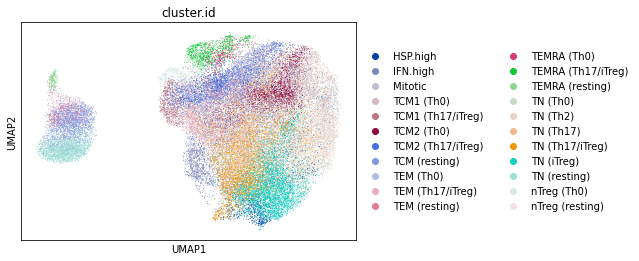

In [8]:
sc.pl.umap(dic_data_proc['canogamez'], color='cluster.id')

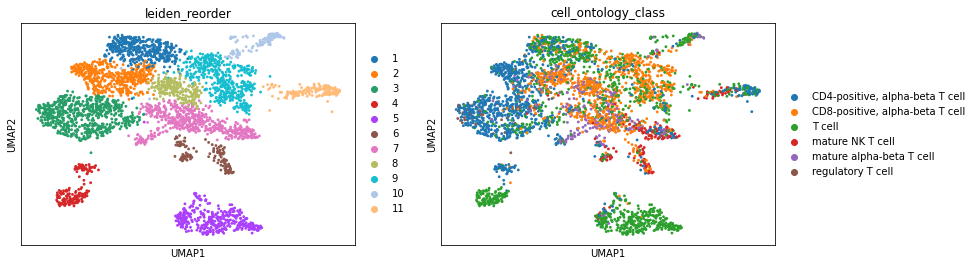

In [10]:
sc.pl.umap(dic_data_proc['tms_facs'], color=['leiden_reorder', 'cell_ontology_class'])

In [5]:
(dic_data_proc['tms_facs'].obs['cell_ontology_class'] == 'regulatory T cell').sum()

46

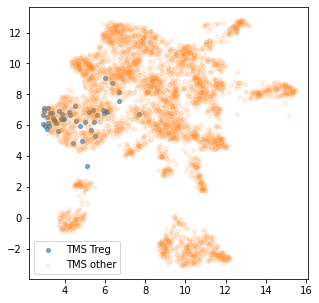

In [8]:
adata = dic_data_proc['tms_facs']
df_plot = pd.DataFrame(index=adata.obs_names, 
                       data={'UMAP1':adata.obsm['X_umap'][:,0],
                             'UMAP2':adata.obsm['X_umap'][:,1]})
df_plot = df_plot.join(adata.obs[['cell_ontology_class']])

ind_select = df_plot['cell_ontology_class'] == 'regulatory T cell'

plt.figure(figsize=[5,5])
plt.scatter(df_plot.loc[ind_select, 'UMAP1'], df_plot.loc[ind_select, 'UMAP2'], s=16, alpha=0.6, 
            label='TMS Treg')
plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'], s=16, alpha=0.1,
            label='TMS other')
plt.legend()
plt.show()

### Joint harmony + umap

In [95]:
# Build combined data 
adata = dic_data_raw['tms_facs'][dic_data_proc['tms_facs'].obs_names].copy()
adata.obs = adata.obs.join(dic_data_proc['tms_facs'].obs[['leiden_reorder']])
# cell_list = np.random.choice(dic_data_raw['canogamez'].obs_names, size=10000, replace=False)
# adata_ref = dic_data_raw['canogamez'][cell_list, :].copy()
adata_ref = dic_data_raw['canogamez'].copy()
adata_ref.var_names = [DIC_MAP_H2M[x] if x in DIC_MAP_H2M else x for x in adata_ref.var_names]
adata = anndata.AnnData.concatenate(adata, adata_ref, batch_categories=['tms_facs', 'canogamez'])

# Processing
print('# Before filter: n_cell=%d'%adata.shape[0])
sc.pp.filter_cells(adata, min_genes=250)
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
print('# After filter: n_cell=%d'%adata.shape[0])
# adata.obs['batch_harmony'] = [('%s.%s'%(x,y)).replace('.nan','') 
#                               for x,y in zip(adata.obs['batch'], adata.obs['mouse.id'])]
adata.obs['batch_harmony'] = adata.obs['batch']
adata.obs['batch_harmony'] = adata.obs['batch_harmony'].astype('category')

sc.pp.highly_variable_genes(adata, subset = False, min_disp=.5, 
                            min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None)
sc.pp.scale(adata, max_value=10, zero_center=False)
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.external.pp.harmony_integrate(adata, key='batch_harmony', max_iter_harmony=20)
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=20, use_rep="X_pca_harmony")
sc.tl.leiden(adata, resolution=0.7)   
sc.tl.umap(adata)

# Before filter: n_cell=46881
# After filter: n_cell=46881


2022-01-25 18:14:50,741 - harmonypy - INFO - Iteration 1 of 20
2022-01-25 18:15:05,875 - harmonypy - INFO - Iteration 2 of 20
2022-01-25 18:15:21,037 - harmonypy - INFO - Converged after 2 iterations


... storing 'FACS.selection' as categorical
... storing 'age' as categorical
... storing 'cell' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'free_annotation' as categorical
... storing 'method' as categorical
... storing 'mouse.id' as categorical
... storing 'sex' as categorical
... storing 'subtissue' as categorical
... storing 'tissue' as categorical
... storing 'tissue_celltype' as categorical
... storing 'leiden_reorder' as categorical
... storing 'cell.type' as categorical
... storing 'cytokine.condition' as categorical
... storing 'donor.id' as categorical
... storing 'Phase' as categorical
... storing 'cluster.id' as categorical


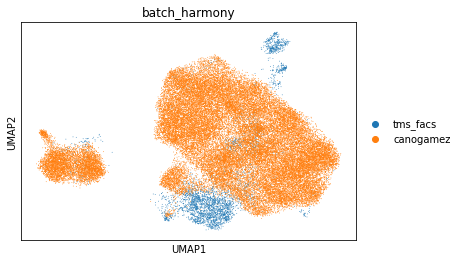

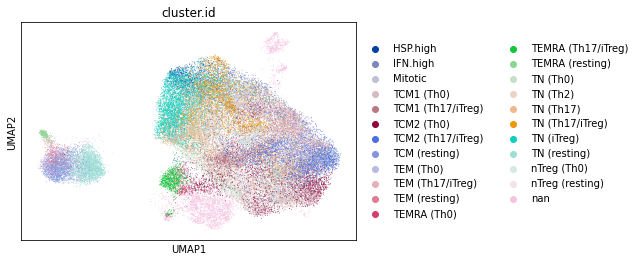

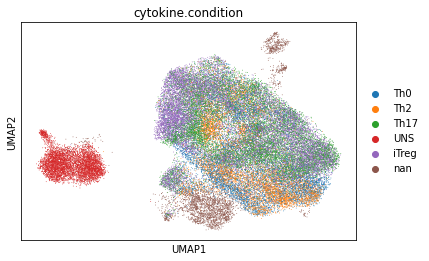

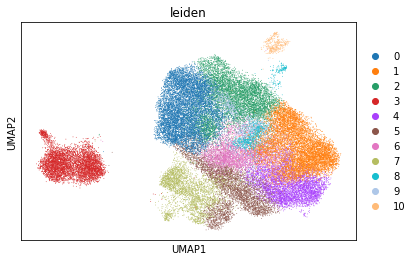

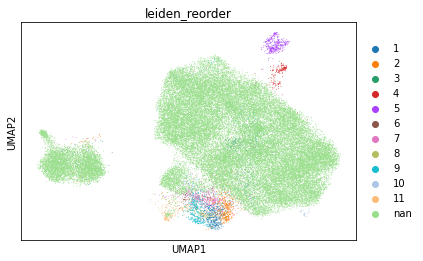

In [96]:
sc.pl.umap(adata, color='batch_harmony')
sc.pl.umap(adata, color=['cluster.id'])
sc.pl.umap(adata, color=['cytokine.condition'])
sc.pl.umap(adata, color=['leiden'])
sc.pl.umap(adata, color=['leiden_reorder'])
# sc.pl.umap(adata, color=['age', 'sex', 'mouse.id'])

In [106]:
ind_select_cluster.sum()

370

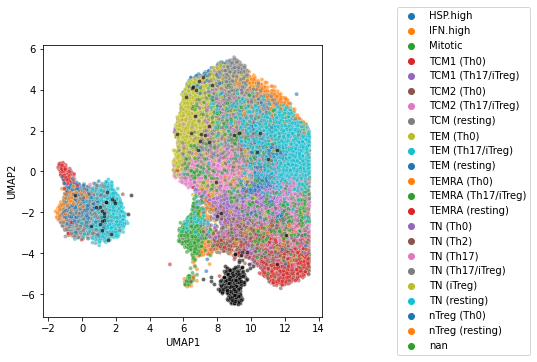

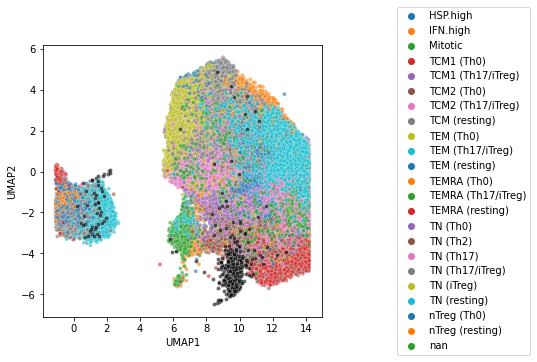

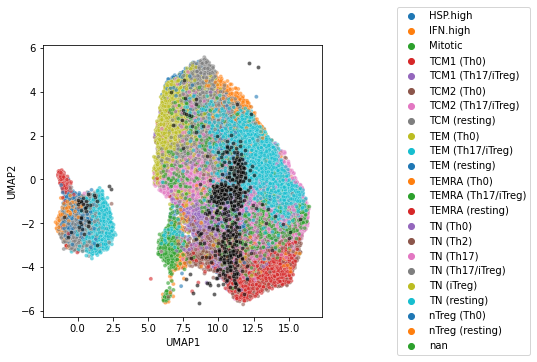

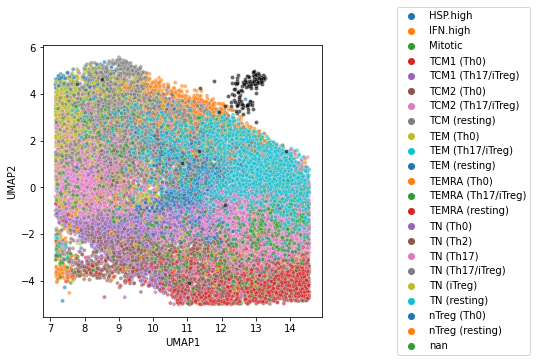

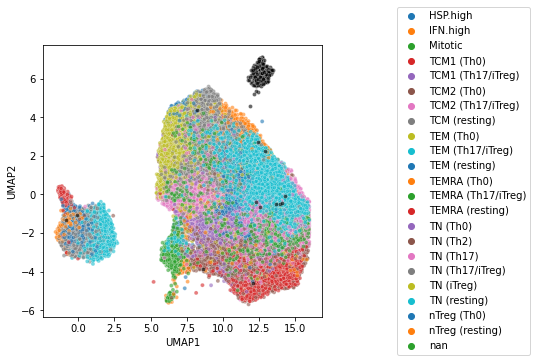

In [120]:
# Only show the cluster of interest
for cluster in ['1', '2', '3', '4', '5', ]:
    df_plot = pd.DataFrame(index=adata.obs_names, 
                           data={'UMAP1':adata.obsm['X_umap'][:,0],
                                 'UMAP2':adata.obsm['X_umap'][:,1]})
    df_plot = df_plot.join(adata.obs[['cluster.id', 'cell.type', 'cytokine.condition', 
                                      'leiden', 'leiden_reorder', 'batch_harmony']])
    
    ind_select_cluster = df_plot['leiden_reorder'] == cluster
    x_min,x_max = df_plot.loc[ind_select_cluster, 'UMAP1'].min(),df_plot.loc[ind_select_cluster, 'UMAP1'].max()
    y_min,y_max = df_plot.loc[ind_select_cluster, 'UMAP2'].min(),df_plot.loc[ind_select_cluster, 'UMAP2'].max()
    x_min = x_min - (x_max-x_min) * 0.1
    x_max = x_max + (x_max-x_min) * 0.1
    y_min = y_min - (y_max-y_min) * 0.1
    y_max = y_max + (y_max-y_min) * 0.1
    
    ind_select = (df_plot['UMAP1']>x_min) & (df_plot['UMAP1']<x_max) & \
        (df_plot['UMAP2']>y_min) & (df_plot['UMAP2']<y_max) & (df_plot['batch_harmony']=='canogamez')
       
    plt.figure(figsize=[5,5])
    g = sns.scatterplot(data=df_plot.loc[ind_select], x='UMAP1', y='UMAP2', 
                        hue='cluster.id', s=16, alpha=0.6, palette='tab10')
    sns.scatterplot(data=df_plot.loc[ind_select_cluster], x='UMAP1', y='UMAP2', s=16, alpha=0.6, color='k')
    g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    plt.show()

In [113]:
df_plot['cluster.id'].isna().sum()

0

In [114]:
ind_select.sum()

46800

In [ ]:
df_plot = pd.DataFrame(index=adata.obs_names, 
                           data={'UMAP1':adata.obsm['X_umap'][:,0],
                             'UMAP2':adata.obsm['X_umap'][:,1]})
df_plot = df_plot.join(adata.obs[['cluster.id', 'leiden', 'leiden_reorder']])
df_plot['combine'] = df_plot['cluster.id'].copy()
ind_select = df_plot['combine'].isna()
df_plot.loc[ind_select, 'combine'] = ['C%d'%x for x in df_plot.loc[ind_select, 'leiden_reorder']]

plt.figure(figsize=[8,8])
g = sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='leiden', s=16, alpha=0.6)
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

plt.figure(figsize=[8,8])
g = sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='combine', s=16, alpha=0.6)
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

... storing 'FACS.selection' as categorical
... storing 'age' as categorical
... storing 'cell' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'free_annotation' as categorical
... storing 'method' as categorical
... storing 'mouse.id' as categorical
... storing 'sex' as categorical
... storing 'subtissue' as categorical
... storing 'tissue' as categorical
... storing 'tissue_celltype' as categorical
... storing 'leiden_reorder' as categorical
... storing 'cell.type' as categorical
... storing 'cytokine.condition' as categorical
... storing 'donor.id' as categorical
... storing 'Phase' as categorical
... storing 'cluster.id' as categorical


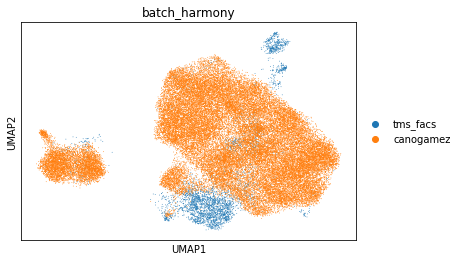

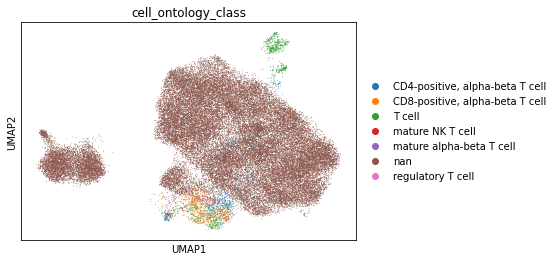

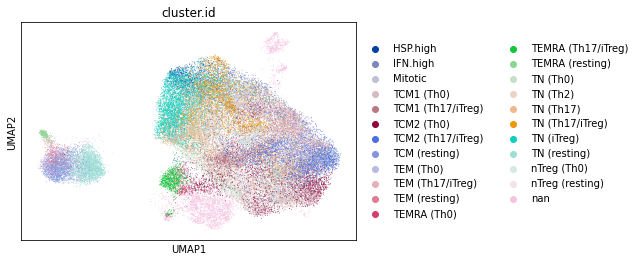

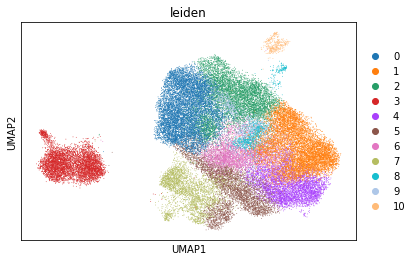

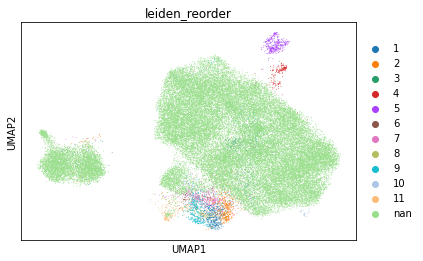

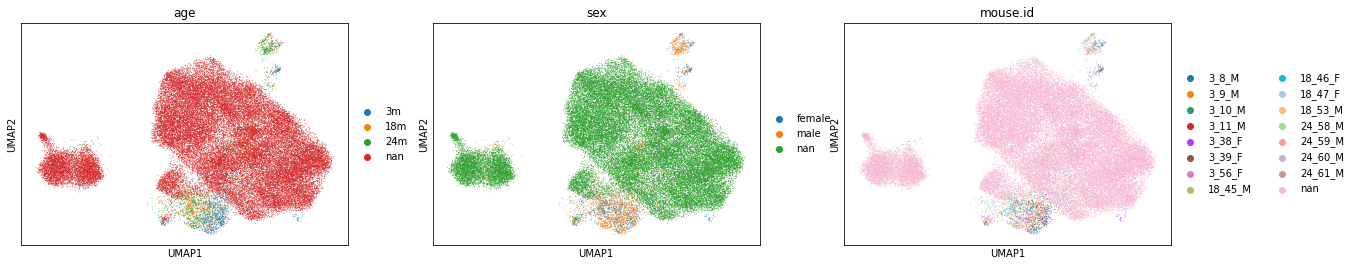

In [61]:
sc.pl.umap(adata, color='batch_harmony')
sc.pl.umap(adata, color=['cell_ontology_class'])
sc.pl.umap(adata, color=['cluster.id'])
sc.pl.umap(adata, color=['leiden'])
sc.pl.umap(adata, color=['leiden_reorder'])
sc.pl.umap(adata, color=['age', 'sex', 'mouse.id'])

### Check markers 

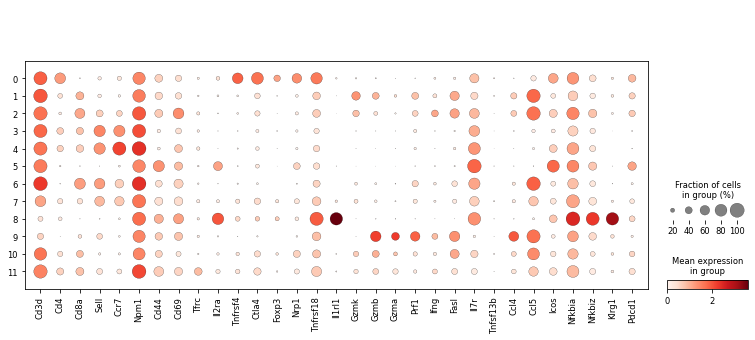

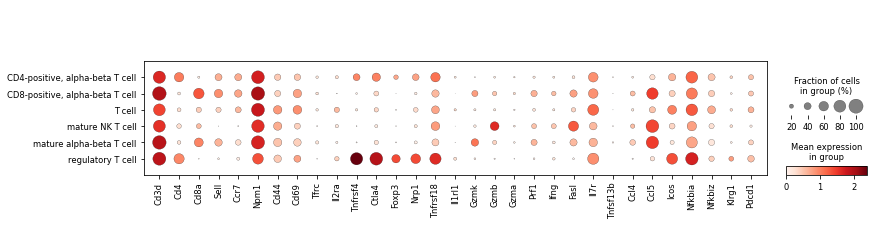

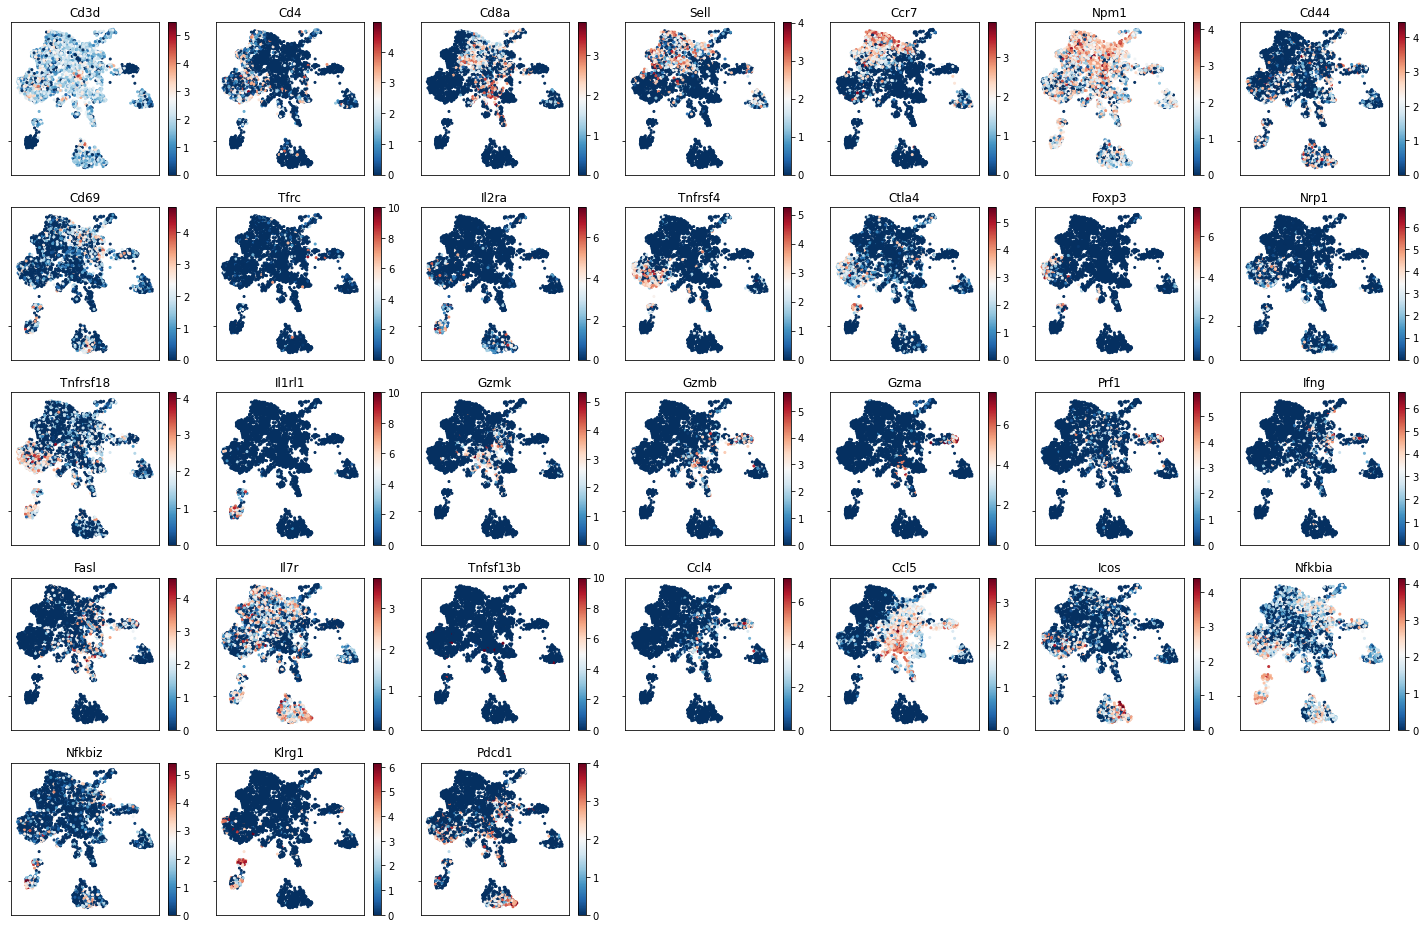

In [70]:
# Annotation info: marker gene expression
marker_list = ['Cd3d', 'Cd4', 'Cd8a', # Basic
               'Sell', 'Ccr7', 'Npm1', 'Cd44', # Naive Cd44-               
               'Cd69', 'Tfrc', 'Il2ra', 'Tnfrsf4', # Activation: Cd69, Cd71, Cd25 (also Treg)
               'Ctla4', 'Foxp3', 'Nrp1', 'Tnfrsf18', 'Il1rl1', # Treg
               'Gzmk', 'Gzmb', 'Gzma', 'Prf1', 'Ifng', 'Fasl', # Cd8+ cytotoxic T cells
               'Il7r', 'Tnfsf13b', 'Ccl4', 'Ccl5', # effector memory
               'Icos', 'Nfkbia', 'Nfkbiz', 'Klrg1', 'Pdcd1', # Others
              ]

adata = dic_data_proc['facs'].copy()
temp_df = adata.obs.groupby(['leiden']).agg({'cell':len})
cluster_list = list(temp_df.index[temp_df['cell']>100])
adata = adata[adata.obs['leiden'].isin(cluster_list)]

for gene in marker_list.copy():
    if gene not in adata.var_names:
        print(gene)
        marker_list.remove(gene)
        
# Dotplot 
sc.pl.dotplot(adata, marker_list, groupby='leiden')
sc.pl.dotplot(adata, marker_list, groupby='cell_ontology_class')

# Scatter plot
df_plot = pd.DataFrame(index=adata.obs_names,
                       data={'UMAP1':adata.obsm['X_umap'][:,0],
                             'UMAP2':adata.obsm['X_umap'][:,1]})
for gene in marker_list:
    df_plot[gene] = adata[:, gene].X.toarray()

plt.figure(figsize=[20,13])
for igene,gene in enumerate(marker_list):
    plt.subplot(5,7,igene+1)
    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot[gene],
                cmap='RdBu_r', s=4)
    plt.colorbar()
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([0],[''])
    plt.yticks([0],[''])
    plt.title(gene)

plt.tight_layout()
plt.show()

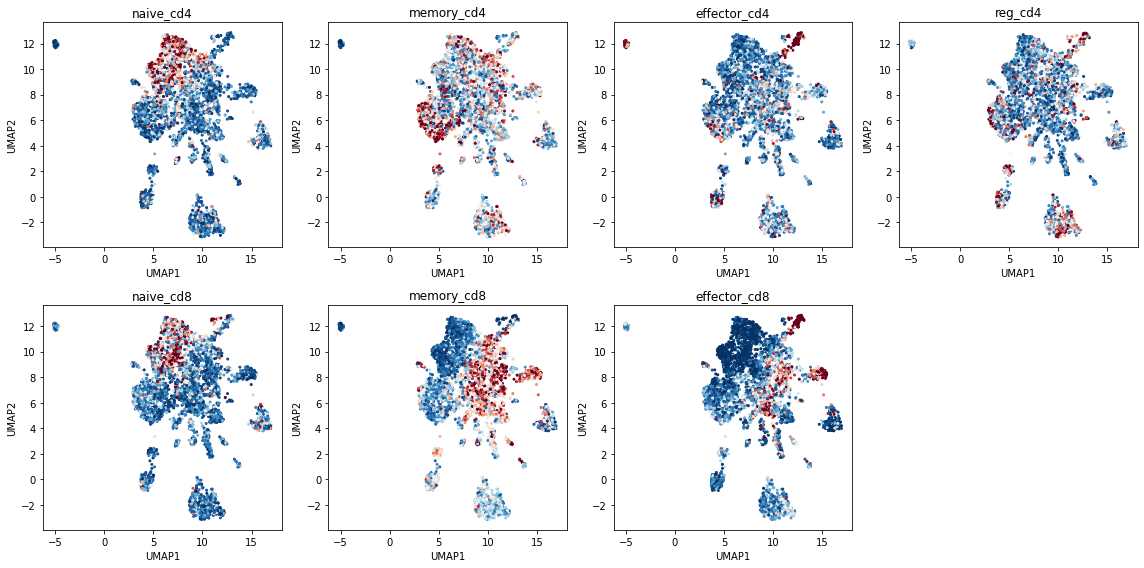

In [71]:
# Annotation info: tsig scores
adata = dic_data_proc['facs'].copy()
trait_list_plot = DIC_TRAIT_LIST['facs_tsig']
ds = 'facs'
score_name = 'facs_tsig'
nrow,ncol =2,4

plt.figure(figsize=[16, 8])
for i_trait,trait in enumerate(trait_list_plot):
    plt.subplot(nrow,ncol,i_trait+1)
    df_plot = pd.DataFrame(index=dic_data_proc[ds].obs_names,
                           data={'UMAP1':dic_data_proc[ds].obsm['X_umap'][:,0],
                                 'UMAP2':dic_data_proc[ds].obsm['X_umap'][:,1]})
    df_plot = df_plot.loc[list(set(df_plot.index) & set(dic_score[score_name].index))]
    df_plot = df_plot.join(dic_score[score_name]['%s.nlog10_pval'%trait])

    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot['%s.nlog10_pval'%trait],
                cmap='RdBu_r', vmax=np.quantile(df_plot['%s.nlog10_pval'%trait], q=0.95), vmin=0, s=4)
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title(trait)

plt.tight_layout()
plt.show()